In [1]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.3.4


In [4]:
data_dir = 'asl_alphabet_train'

list_ds = tf.data.Dataset.list_files(str(data_dir + '/*/*.jpg'), shuffle=False)
image_count = len(list_ds)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

class_names = np.array(sorted([item.name for item in os.scandir(data_dir)]))
num_classes = len(class_names)

In [161]:
class_names

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'del', 'nothing', 'space'], dtype='<U7')

In [5]:
print(f"The total number of images in the dataset is {image_count}.")
print(f"The number of different classes is {num_classes}.")

The total number of images in the dataset is 87000.
The number of different classes is 29.


In [199]:
batch_size = 10
img_height = 227
img_width = 227
channel = 3

In [200]:
# # Splitting into training and validation sets
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [201]:
def preprocess_image(file_path):
    # Load the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=channel)
    img = tf.image.resize(img, [img_height, img_width])

    # Data augmentation
    img = tf.image.random_flip_left_right(img)  # Randomly flip the image left to right
    img = tf.image.random_brightness(img, max_delta=0.9)  # Randomly adjust the brightness
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)  # Randomly adjust the contrast

    # Rescale pixel values
    img /= 255.0
    return img

In [202]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2] == class_names
    # Convert boolean tensor to integers
    label = tf.cast(label, tf.int32)
    first_label = tf.gather(label, 0)
    return label

In [203]:
train_ds = train_ds.map(lambda x: (preprocess_image(x), get_label(x)),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

val_ds = val_ds.map(lambda x: (preprocess_image(x), get_label(x)),
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)

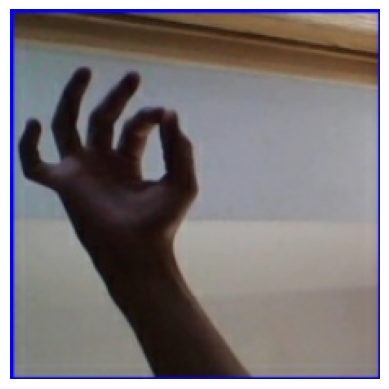

In [217]:
image, label = next(iter(val_ds.take(2)))

# Access the label of the first example
first_label = image[0]

plt.imshow(first_label, cmap="gray")
plt.axis('off')
plt.show()

In [205]:
model = Sequential()

# Add the layers to the model with the specified input shape
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(img_height, img_width, channel), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [206]:
# Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 57, 57, 96)        34944     
_________________________________________________________________
batch_normalization_4 (Batch (None, 57, 57, 96)        384       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 384)      

In [207]:
# Define early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,           # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights to those that achieved the best value of the monitored metric
)

# Train the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]  # Include early stopping callback
)

Epoch 1/10
6960/6960 [==============================] - 362s 52ms/step - loss: 1.2324 - accuracy: 0.6130 - val_loss: 0.1754 - val_accuracy: 0.9428
Epoch 2/10
6960/6960 [==============================] - 335s 48ms/step - loss: 0.1454 - accuracy: 0.9512 - val_loss: 0.1993 - val_accuracy: 0.9430
Epoch 3/10
6960/6960 [==============================] - 400s 57ms/step - loss: 0.0561 - accuracy: 0.9816 - val_loss: 0.0212 - val_accuracy: 0.9928
Epoch 4/10
6960/6960 [==============================] - 344s 49ms/step - loss: 0.0351 - accuracy: 0.9890 - val_loss: 0.0062 - val_accuracy: 0.9983
Epoch 5/10
6960/6960 [==============================] - 345s 50ms/step - loss: 0.0211 - accuracy: 0.9938 - val_loss: 0.0030 - val_accuracy: 0.9993
Epoch 6/10
6960/6960 [==============================] - 336s 48ms/step - loss: 0.0154 - accuracy: 0.9956 - val_loss: 0.0090 - val_accuracy: 0.9973
Epoch 7/10
6960/6960 [==============================] - 353s 51ms/step - loss: 0.0144 - accuracy: 0.9955 - val_loss: 0

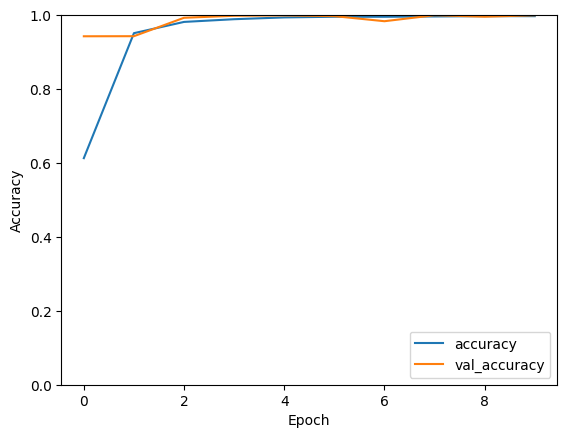

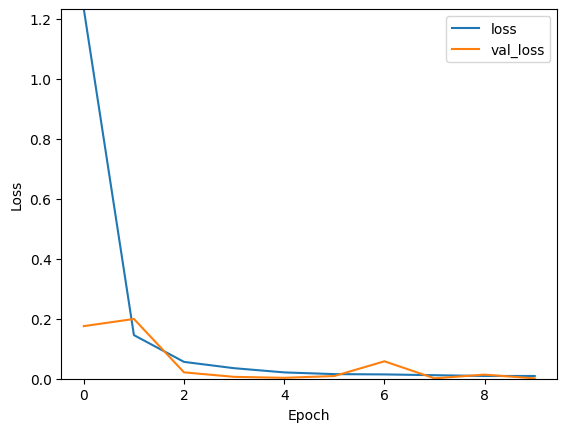

In [208]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(np.max(history.history['loss']), np.max(history.history['val_loss']))])
plt.legend(loc='upper right')
plt.show()

In [209]:
evaluation = model.evaluate(val_ds)

# Print the evaluation results
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

1740/1740 [==============================] - 37s 21ms/step - loss: 9.7544e-04 - accuracy: 0.9997
Validation Loss: 0.0009754380444064736
Validation Accuracy: 0.9997126460075378


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       577
           1       1.00      1.00      1.00       601
           2       1.00      1.00      1.00       630
           3       1.00      1.00      1.00       595
           4       1.00      1.00      1.00       606
           5       1.00      1.00      1.00       603
           6       1.00      1.00      1.00       625
           7       1.00      1.00      1.00       576
           8       1.00      1.00      1.00       606
           9       1.00      1.00      1.00       581
          10       1.00      1.00      1.00       615
          11       1.00      1.00      1.00       578
          12       1.00      1.00      1.00       615
          13       1.00      1.00      1.00       602
          14       1.00      1.00      1.00       607
          15       1.00      1.00      1.00       583
          16       1.00      1.00      1.00       615
          17       1.00    

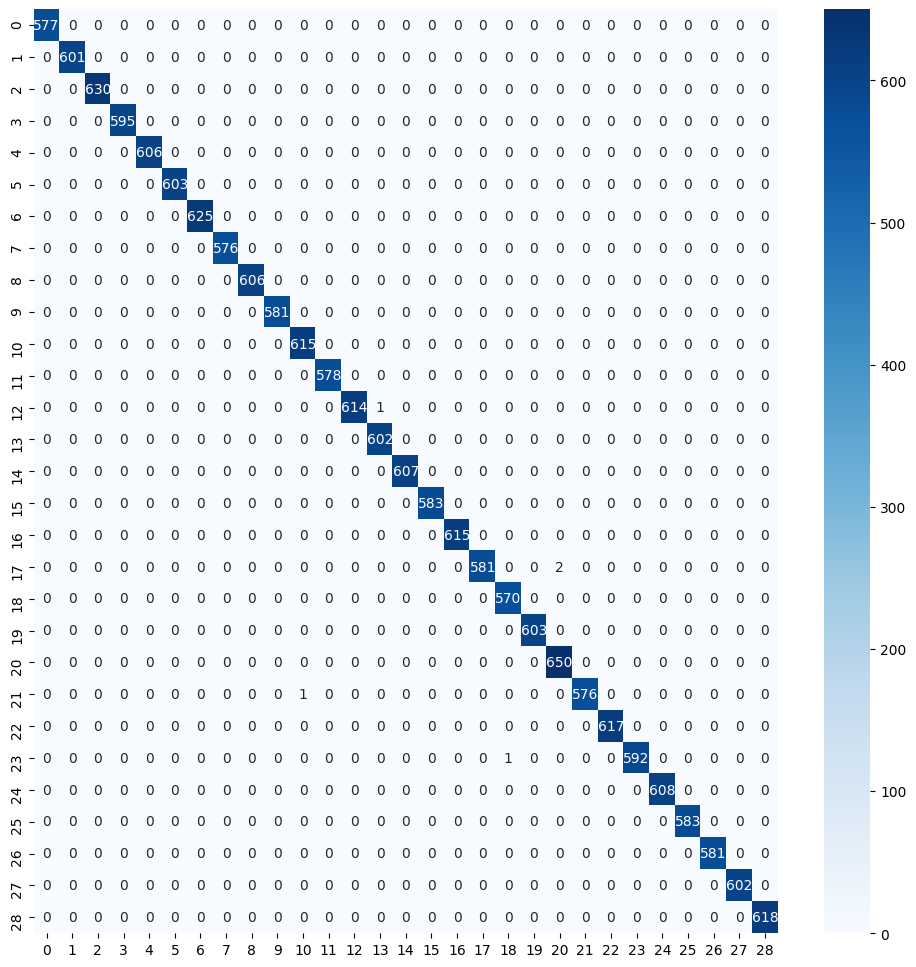

In [210]:
# Initialize empty lists to store true labels and predictions
true_labels = []
predictions = []

# Iterate over the test dataset to extract true labels and predictions
for images, labels in val_ds:
    true_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot encoded labels to categorical labels
    predictions.extend(np.argmax(model.predict(images), axis=1))  # Get predictions

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Print classification report
print(classification_report(true_labels, predictions))

# Plot confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt="d", cmap="Blues")
plt.show()

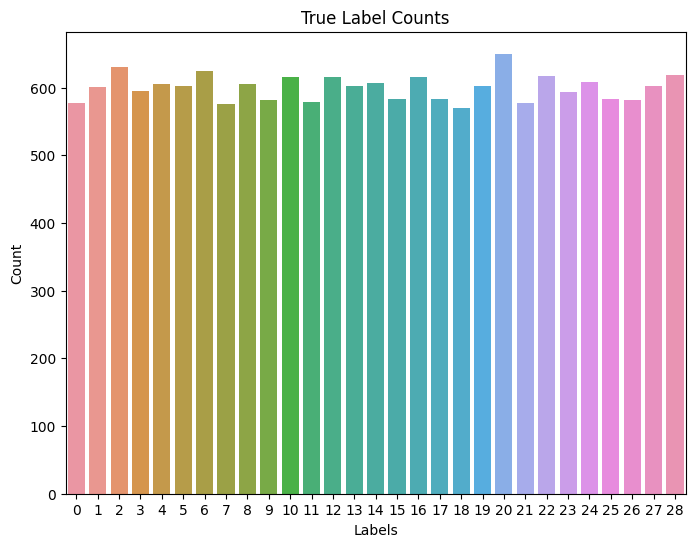

In [211]:
# Plot label counts
plt.figure(figsize=(8, 6))
sns.countplot(x=true_labels)
plt.title('True Label Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [212]:
model.save("sign_language.h5")